In [1]:
!pip install polars
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import pymc3 as pm
import pandas as pd
import polars as pl
import theano
import seaborn as sns
%matplotlib inline


#Convert effect sizes from r to Cohen's D 
r_to_d = lambda r: r/np.sqrt(1-r**2)

<h1>Psychology RPP</h1>

In [2]:
#Load RPP Data, randomize direction. 
df_psych = pl.read_csv('./data/rpp_data.csv',ignore_errors=True).filter(
    (pl.col('T_pval_USE..R.').is_not_null()) & 
    (pl.col('T_pval_USE..O.').is_not_null()) &
    (pl.col('T_r..R.').is_not_null()) &
    (pl.col('T_r..O.').is_not_null()) 
).with_columns([
    (r_to_d(pl.col('T_r..R.').cast(float))).alias("d_r"),
    (r_to_d(pl.col('T_r..O.').cast(float))).alias("d_o"),
    pl.col('N (R)').cast(int).alias("n_r"),
    pl.col('N (O)').cast(int).alias("n_o"),
]).select([
    'd_o','d_r','n_o','n_r'
]).filter((pl.col("n_o") < 2000))
df_psych.head(5)
df_psych['direction'] = np.random.choice(np.array([-1,1]), df_psych.shape[0])


In [4]:
with pm.Model() as m_1:
    #Hyperpriors
    sigma = pm.Exponential("sigma", 1)
    tau = pm.Exponential("tau", 1)

    #Priors
    noise_r = pm.Normal('noise_o', 0, sigma=sigma,shape=df_psych.shape[0])
    noise_o = pm.Normal('noise_r',0, sigma=sigma,shape=df_psych.shape[0])
    signal = pm.Normal('signal',0,tau,shape=df_psych.shape[0])
    bias = pm.Gamma('bias', 1,.5, shape=df_psych.shape[0])
    
    #Epsilon
    s_o=1/pm.math.sqrt(df_psych.n_o)
    s_r=1/pm.math.sqrt(df_psych.n_r)

    #Model
    d_o = pm.Normal("d_o", mu=noise_o + signal + bias * df_psych.direction, 
                    sigma=s_o, observed=df_psych.direction*df_psych.d_o)
    d_r = pm.Normal("d_r", mu=noise_r + signal, 
                    sigma=s_r, observed=df_psych.direction*df_psych.d_r)

In [5]:
with m_1:
    #Prior checks and sampling
    prior_checks = pm.sample_prior_predictive(
        samples=50, 
        random_seed=42
    )

    #Sampling
    trace_1 = pm.sample(
        cores=4,
        target_accept=0.95, 
        random_seed=42
    )

    #Posterior Predictive Checks
    ppc = pm.sample_posterior_predictive(
        trace_1, 
        var_names=["d_o", "d_r", "signal","bias"], 
        random_seed=42
    )

    #Convert to ArViZ
    idata_1 = az.from_pymc3(
        trace_1, 
        prior=prior_checks, 
        posterior_predictive=ppc
    )

/tmp/ipykernel_10085/33972593.py:9: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_1 = pm.sample(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bias, signal, noise_r, noise_o, tau, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


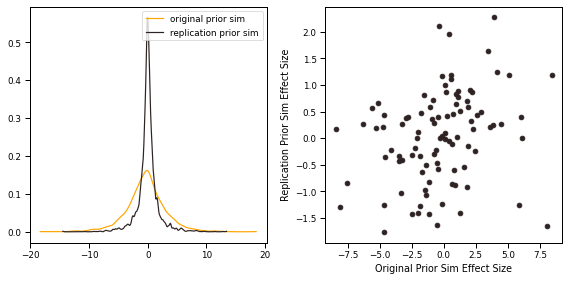

In [25]:
plt.figure(figsize=(8,4))
plt.subplot(121)
az.plot_dist(prior_checks['d_o'],color='orange',label='original prior sim')
az.plot_dist(prior_checks['d_r'],label='replication prior sim')

plt.subplot(122)
plt.scatter(prior_checks['d_o'][0,:],prior_checks['d_r'][0,:])
plt.xlabel('Original Prior Sim Effect Size')
plt.ylabel('Replication Prior Sim Effect Size')
plt.tight_layout()

In [7]:
az.summary(idata_1,var_names=['sigma','tau','bias'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,0.170,0.058,0.080,0.288,0.007,0.005,67.0,171.0,1.05
tau,0.317,0.053,0.214,0.418,0.005,0.004,120.0,235.0,1.03
bias[0],0.626,0.301,0.072,1.183,0.005,0.004,3105.0,2036.0,1.00
bias[1],0.607,0.307,0.042,1.145,0.005,0.004,3370.0,2239.0,1.00
bias[2],0.589,0.290,0.026,1.075,0.005,0.003,2931.0,1936.0,1.00
...,...,...,...,...,...,...,...,...,...
bias[91],0.384,0.226,0.002,0.767,0.004,0.003,3447.0,2492.0,1.00
bias[92],0.246,0.197,0.000,0.601,0.007,0.006,954.0,1391.0,1.01
bias[93],0.440,0.261,0.001,0.866,0.005,0.004,2222.0,1925.0,1.00
bias[94],0.429,0.239,0.001,0.818,0.004,0.003,3178.0,2193.0,1.00


array([<AxesSubplot:xlabel='d_o / d_o'>, <AxesSubplot:xlabel='d_r / d_r'>],
      dtype=object)

/opt/conda/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


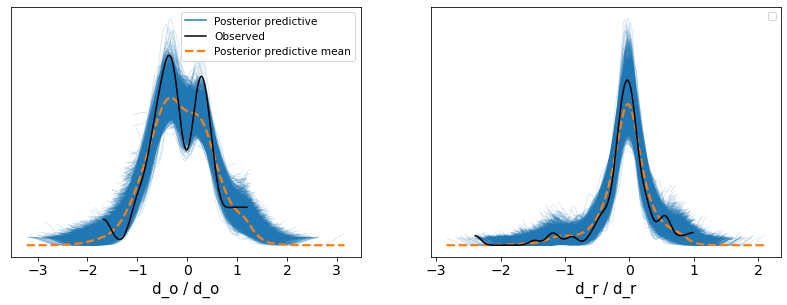

In [8]:
az.plot_ppc(idata_1, colors=["C0", "k", "C1"])

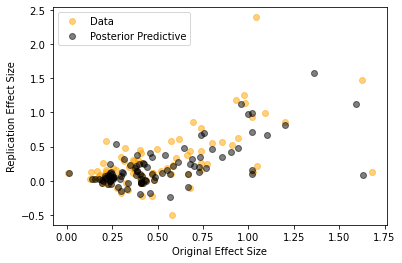

In [15]:
_, ax = plt.subplots()

ax.plot(df_psych['d_o'].to_numpy(), df_psych['d_r'].to_numpy(),'o',color='orange',alpha=.5,label='Data')
ax.plot(df_psych['direction'].to_numpy()*ppc['d_o'].mean(axis=0), 
       df_psych['direction'].to_numpy()*ppc['d_r'].mean(axis=0),'o',c='k',alpha=.5,label='Posterior Predictive')
plt.xlabel('Original Effect Size')
plt.ylabel('Replication Effect Size')
plt.legend()

<h1>Simulations</h1>

In [20]:
from statsmodels.stats.power import tt_solve_power,tt_ind_solve_power
def simulate_reproducibility(row,f=96.0/99.0):
    count = row[0]
    N = row[1]
    j = row[2]
    alpha = row[3]
    chain = np.random.choice(4,j,replace=True)
    sample = np.random.choice(1000,j,replace=True)

    signals = np.abs(np.random.normal(0,idata_1['posterior']['tau'][chain,sample])).ravel()
    es = signals + np.random.normal(0, idata_1['posterior']['sigma'][chain,sample]).ravel()
    
    power = tt_ind_solve_power(effect_size=es,
                                         nobs1=np.round(N/2).astype('int'),
                                         alpha=alpha)
    p_success = np.mean(power)
    published = np.random.binomial(1,(f*power)+(1-f)*(1-power))
    observed_es = es[published==1]
    actual_es = signals[published==1]
    
    type_s= tt_ind_solve_power(effect_size=es,
                               nobs1=np.round(N/2).astype('int'),
                               alpha=alpha,
                               alternative='smaller')
    
    rep_es = signals[published==1] + \
            np.random.normal(0, np.array(idata_1['posterior']['sigma'][chain,sample]).ravel()[published==1])
    rep_ss = np.round(N/2).astype('int')

    rep_power = tt_ind_solve_power(effect_size=rep_es,
                                            alpha=.025,nobs1=rep_ss,alternative='larger')
    reversal = tt_ind_solve_power(effect_size=rep_es,
                                            alpha=.025,nobs1=rep_ss,alternative='smaller')
    p_rep_success = np.mean(rep_power)
    return (p_success, 
            p_rep_success, 
            np.mean(type_s), 
            np.mean(observed_es), 
            np.mean(signals[published==1]),
            np.mean(reversal),
            np.mean(rep_es))
            

In [21]:
N = np.linspace(10,500,50,dtype=int) #Sample Size
j = 100 #Experiments per simulation
alpha = np.array([.005, .01, .05, .1, .2]) #Evaluated Alpha values
replication_simulation_dictionaries = []
for n in N:
    for a in alpha:
        replication_simulation_dictionaries.append({'N':n, 'j':j, 'alpha':a})

out_psych = pl.DataFrame(replication_simulation_dictionaries).with_row_count().apply(
    simulate_reproducibility).rename(
    dict(zip(['column_' + str(idx) for idx in range(7)], 
                   ['publication_rate',
                    'replication_rate', 
                    'type_s_error',
                    'published_es',
                    'actual_es', 
                    'reversals',
                    'replication_es']))
    ).with_row_count().join(
        pl.DataFrame(replication_simulation_dictionaries).with_row_count(),
        on='row_nr'
    ).drop('row_nr')

In [22]:
out_psych.to_csv('./output/psych_sims.csv')
out_psych.head()

publication_rate,replication_rate,type_s_error,published_es,actual_es,reversals,replication_es,N,j,alpha
f64,f64,f64,f64,f64,f64,f64,i64,i64,f64
0.010893,0.075009,0.002983,0.312181,0.291489,0.014547,0.279817,10,100,0.005
0.020032,0.073504,0.005921,0.3061,0.281042,0.013564,0.283699,10,100,0.01
0.081562,0.079509,0.029729,0.347545,0.3138,0.012864,0.309537,10,100,0.05
0.146039,0.078354,0.061954,0.331545,0.303326,0.0137,0.300481,10,100,0.1
0.261905,0.077508,0.127075,0.321307,0.298868,0.013144,0.301922,10,100,0.2


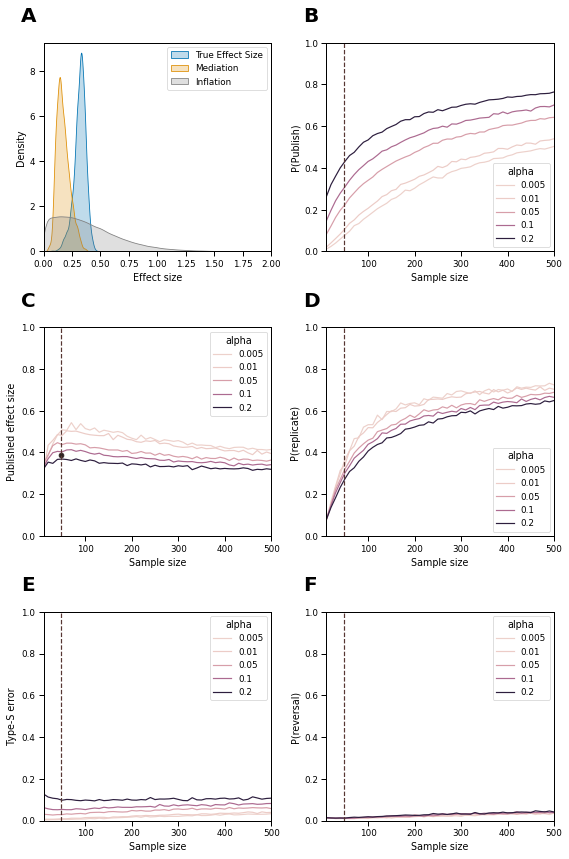

In [28]:
pal = sns.color_palette("colorblind", n_colors=6)
sim_data = out_psych.to_pandas()
def plot_fig4a(samples_full,axs):
    sns.kdeplot(np.abs(np.array(samples_full['tau']).ravel()),label='True Effect Size',clip=[0,3],
                shade=True,color=pal[0],ax=axs)
    sns.kdeplot(np.abs(np.array(samples_full['sigma']).ravel()),label='Mediation',clip=[0,3],
                shade=True,color=pal[1],ax=axs)
    sns.kdeplot(np.abs(np.array(samples_full['bias']).ravel()),label='Inflation',clip=[0,3],
            shade=True,color='grey',ax=axs)
    axs.legend()
    axs.set_xlim([0,2])
    axs.set_xlabel('Effect size')
    
def plot_sims(data, y_var,axs, x_var="N",hue='alpha'):
    sns.lineplot(x=x_var, y=y_var,
             hue="alpha", 
             data=data,ax=axs)   

    axs.set_ylim(0,1)
    axs.plot([48,48],[0,1],ls='--')
    axs.set_xlim(np.min(data[x_var]),np.max(data[x_var]))
    axs.set_xlabel('Sample size')

    
sns.set_context('paper',font_scale=1)
sns.set_palette(sns.color_palette("dark:salmon"))

fig, axs = plt.subplots(3,2,figsize=(8,12))

res = 100

    
plot_fig4a(idata_1['posterior'],axs[0][0])

plot_sims(sim_data, "publication_rate",axs[0][1])
axs[0][1].set_ylabel("P(Publish)")


plot_sims(sim_data, "published_es",axs[1][0])
axs[1][0].set_ylabel("Published effect size")
mu_a = np.mean(sim_data['actual_es'])


plot_sims(sim_data, "replication_rate",axs[1][1])
axs[1][1].set_ylabel("P(replicate)")
axs[1][0].scatter(df_psych['n_o'].median(), .39)



plot_sims(sim_data, "type_s_error",axs[2][0])
axs[2][0].set_ylabel("Type-S error")


plot_sims(sim_data, "reversals",axs[2][1])
axs[2][1].set_ylabel("P(reversal)")



axs = axs.flat
import string
for n, ax in enumerate(axs):
    ax.text(-0.1, 1.1, string.ascii_uppercase[n], transform=ax.transAxes, 
            size=20, weight='bold')
plt.tight_layout()
plt.savefig('./output/figure4.png',dpi=750)